In [2]:
import json
from pathlib import Path
from tqdm import tqdm
import pyvips

INPUT_DIR  = Path("data/SFPI/images/train")
TRAIN_JSON = Path("data/SFPI/Annotations/train_annotation.json")
VAL_JSON   = Path("data/SFPI/Annotations/val_annotation.json")
OUT_DIR    = Path("data/sfpi_quarter")
(OUT_DIR/"images/train").mkdir(parents=True, exist_ok=True)
(OUT_DIR/"images/val").mkdir(parents=True, exist_ok=True)
(OUT_DIR/"annotations").mkdir(parents=True, exist_ok=True)

def load_coco(path):
    return json.loads(path.read_text())

def shrink(path, out_path):
    img = pyvips.Image.new_from_file(str(path), access="sequential")
    img = img.shrink(4, 4)          # exact 1/4 on both dims
    img.write_to_file(str(out_path))

def process(coco, img_out):
    new_imgs, new_anns = [], []
    for info in tqdm(coco["images"], desc=img_out.name):
        fn = info["file_name"]
        src = INPUT_DIR / fn
        dst = img_out / fn
        shrink(src, dst)

        # get dims from the vip image
        with pyvips.Image.new_from_file(str(dst)) as im2:
            nw, nh = im2.width, im2.height

        new_imgs.append({"id": info["id"], "file_name": fn, "width": nw, "height": nh})
        for ann in coco["annotations"]:
            if ann["image_id"] != info["id"]:
                continue
            new_anns.append({
                **ann,
                "bbox":         [x/4 for x in ann["bbox"]],
                "area":         ann["area"] / 16,
                "segmentation": [[x/4 for x in seg] for seg in ann.get("segmentation", [])]
            })
    return new_imgs, new_anns

train = load_coco(TRAIN_JSON); val = load_coco(VAL_JSON); cats = train["categories"]
t_imgs, t_anns = process(train, OUT_DIR/"images/train")
v_imgs, v_anns = process(val,   OUT_DIR/"images/val")

for n, imgs, anns in [("train", t_imgs, t_anns), ("val", v_imgs, v_anns)]:
    out = {"images": imgs, "annotations": anns, "categories": cats}
    (OUT_DIR/"annotations"/f"{n}.json").write_text(json.dumps(out))


val: 100%|██████████| 1500/1500 [01:09<00:00, 21.54it/s]


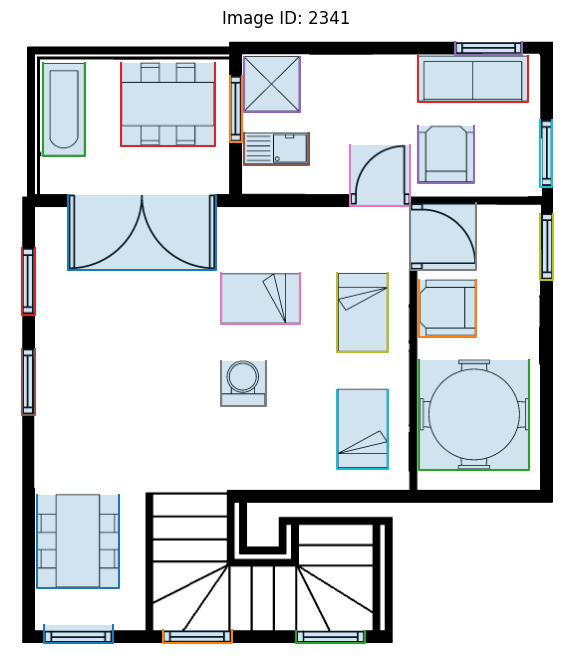

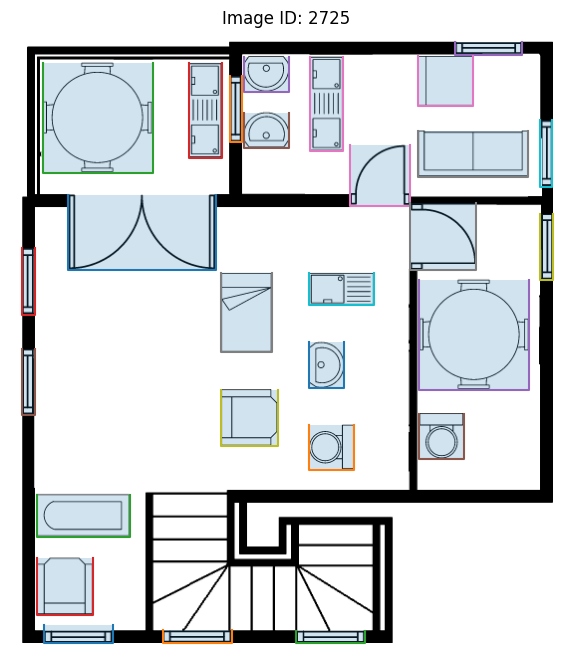

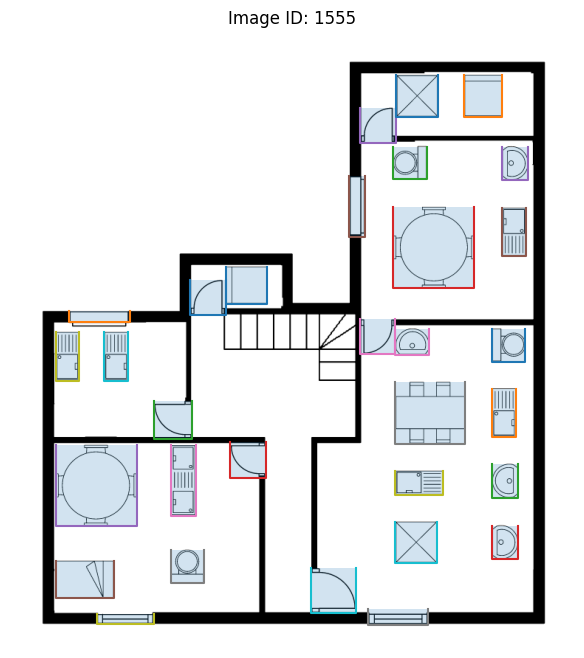

In [6]:
import json
import random
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths: adjust these if your output dir is different
IMAGE_DIR = Path("data/sfpi_quarter/images/train")
ANN_PATH = Path("data/sfpi_quarter/annotations/train.json")

# Load annotations
coco = json.loads(ANN_PATH.read_text())
images_info = {img['id']: img for img in coco['images']}
anns_by_image = {}
for ann in coco['annotations']:
    anns_by_image.setdefault(ann['image_id'], []).append(ann)

# Randomly sample 3 images
sample_ids = random.sample(list(images_info.keys()), 3)

for img_id in sample_ids:
    info = images_info[img_id]
    img_path = IMAGE_DIR / info['file_name']
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    ax = plt.gca()

    # Overlay each annotation
    for ann in anns_by_image.get(img_id, []):
        x, y, w, h = ann['bbox']
        rect = plt.Rectangle((x, y), w, h, fill=True, alpha=0.2)
        ax.add_patch(rect)
        for seg in ann.get('segmentation', []):
            seg_arr = np.array(seg).reshape(-1, 2)
            ax.plot(seg_arr[:, 0], seg_arr[:, 1])

    plt.axis('off')
    plt.title(f"Image ID: {img_id}")
    plt.show()

